# INFO-F-438 - Algorithms in computational biology - 2021

## Assignment 2: Local Sequence Alignment with Anchors

### Name: Hoang Hai Nam
### M. No.: 443146

Python version used and tested : 3.8

Imported libraries: numpy, random, timeit, matplotlib.pyplot

## Pre-requisites

The code for graphing runtimes is provided by Prof. John Iacono, it provides imports as well as functions used to graphs runtime and discuss performance later in the file. Namely plotruntime() and plotruntimes()

Functions are validated in the Validation part, containing different combinations of LSA workings.

## Imports

In [1]:
import numpy as np
import random
import timeit
import matplotlib.pyplot as plt

## Functions

In [2]:
def LSAgrapher(v, w, idp, mmp, fscore=None):
    """Given 2 strings, v and w, indel and mismatch penalties, returns an edit graph,
    as well as value of the highest scoring cell and its coordinates"""
    n = len(v)
    m = len(w)
    maxval = 0
    maxcoord = [0, 0]
    # conversion into lists and adding 0 to the start of the list
    v = list(v)
    v.insert(0, 0)
    w = list(w)
    w.insert(0, 0)
    # creating 2 empty arrays
    s = np.zeros((n + 1, m + 1))
    b = np.zeros((n + 1, m + 1))
    # nested duo loops for going top left to bottom right of ij coordinates
    for i in range(1, n + 1):
        # sets the old rows to be None
        if i >= 2:
            s[i-2] = None
        for j in range(1, m + 1):
            # match case, no penalty for diagonal movement
            if v[i] == w[j]:
                s[i][j] = max(s[i - 1][j] - idp, s[i][j - 1] - idp, s[i - 1][j - 1] + 1, 0)
            # mismatch case, penalty is applied for diagonal movement
            else:
                s[i][j] = max(s[i - 1][j] - idp, s[i][j - 1] - idp, s[i - 1][j - 1] - mmp, 0)
            # cases, directional infos being stored into b
            if s[i][j] == s[i - 1][j] - idp:
                b[i][j] = 1  # North/indel
            elif s[i][j] == s[i][j - 1] - idp:
                b[i][j] = 2  # West/indel
            elif s[i][j] == 0:
                b[i][j] = 4  # SouthEast/premature end
            else:
                b[i][j] = 3  # NorthWest/match or mismatch
            # storing top scoring coordinates and well, score
            if s[i][j] >= maxval and fscore is None:
                maxcoord = [i, j]
                maxval = s[i][j]
            elif fscore is not None:
                if i == fscore[0] and j == fscore[1]:
                    maxval = s[fscore[0]][fscore[1]]
    return maxval, maxcoord, b


def LSABackDual(b, v, w, i, j, res=None):
    """Given an edit graph(b), 2 strings, and starting coordinates,
    returns 2 alternate strings of a local alignment motif"""
    if res is None:
        res = [[], []]
    #base case, with abrupt end included
    if i == 0 or j == 0 or b[i][j] == 4:
        # here when the backtracking reaches its end, the remaining i and j values 
        # are added, this aids in the verbose function later on, as the positional
        # informations are stored here
        res[0].append(i * " ")
        res[1].append(j * " ")
        return res
    # match or mismatch case
    if b[i][j] == 3:
        LSABackDual(b, v, w, i - 1, j - 1, res)
        res[0].append(v[i - 1])
        res[1].append(w[j - 1])
    # unmatching cases
    else:
        if b[i][j] == 1:
            LSABackDual(b, v, w, i - 1, j, res)
            res[0].append(" ")
        else:
            LSABackDual(b, v, w, i, j - 1, res)
            res[1].append(" ")

    return res


def LSABackSing(b, v, i, j, res=None):
    """Modified LSABackDual, given an edit graph, a string and starting coordinates
        returns 1 alignment motif based only on 1 string"""
    if res is None:
        res = []
    if i == 0 or j == 0 or b[i][j] == 4:
        return res
    if b[i][j] == 3:
        LSABackSing(b, v, i - 1, j - 1, res)
        res.append(v[i - 1])
    else:
        if b[i][j] == 1:
            LSABackSing(b, v, i - 1, j, res)
        else:
            LSABackSing(b, v, i, j - 1, res)
    return res


def LSA(s1, s2, idp, mmp, anchor1=None, anchor2=None, verbose=False):
    """Given 2 strings, indel and mismatch penalties,returns optimal local alignment,
        when optional anchors are present, a non-optimal local alignment surrounding the
        anchor is returned instead"""
    # we always have to calculate the first directional graph anyways
    # basic case, no verbose, no need to have the alternate LSA, no need for positional spaces
    if anchor1 == anchor2 is None:
        master = LSAgrapher(s1, s2, idp, mmp)
        if not verbose:
            # returns score, and the answer
            return int(master[0]), ''.join(LSABackSing(master[2], s1, master[1][0], master[1][1], ))
        else:
            # two alternatives of subsequences, as mismatches are allowed with low penalty
            subseqs = LSABackDual(master[2], s1, s2, master[1][0], master[1][1], )
            print(s1)
            print(''.join(subseqs[0]))
            print(s2)
            print(''.join(subseqs[1]))
            # returns tuple containing score, converted list into strings and having all spaces removed
            return int(master[0]), ''.join(subseqs[0]).replace(" ", "")
    elif anchor1 != None and anchor2 != None:
        # generation of the right side edit graph
        master = LSAgrapher(s1, s2, idp, mmp, [anchor1, anchor2])
        # reversal of strings
        s1m = s1[::-1]
        s2m = s2[::-1]
        # generation of mirror edit graph
        mastermir = LSAgrapher(s1m, s2m, idp, mmp, [-anchor1 % len(s1m), -anchor2 % len(s2m)])
        # calculation of right side (right to left from anchor) solution
        rdres = LSABackDual(master[2], s1, s2, anchor1, anchor2, None)
        # calculation of opposite side solution
        ldres = LSABackDual(mastermir[2], s1m, s2m, -anchor1 % len(s1m), -anchor2 % len(s2m), None)
        # gluing the left and right side of anchors together
        sol1 = ''.join(rdres[0]) + ''.join(ldres[0][::-1])
        sol2 = ''.join(rdres[1]) + ''.join(ldres[1][::-1])
        if verbose:
            # anchor position set up
            print((anchor1 - 1) * " " + 'v')
            print(s1)
            print(sol1)
            print((anchor2 - 1) * " " + 'v')
            print(s2)
            print(sol2)
        # adds scores of both allignments together for final score, and strip solution of spaces
        return int(master[0]+mastermir[0]), sol1.replace(" ", "")

def randomString(length):
    letters = "agtc"
    return "".join(random.choice(letters) for i in range(length))

def plotruntime(f,r,trials=1,figsize=[3,3]):
    Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r,Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    
def plotruntimes(functions,labels,r,trials=1,figsize=[3,3]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()


## Validation

In [3]:
S1=randomString(5)+"a"*10+randomString(20)+"b"*20+randomString(10)
S2=randomString(5)+"b"*20+randomString(20)+"a"*10+randomString(10)
print(S1)
print(S2)


gaagaaaaaaaaaaacttggagtatccgcaaaaccbbbbbbbbbbbbbbbbbbbbtgggccgtca
acaggbbbbbbbbbbbbbbbbbbbbggaagttaaagctacgatgtaaaaaaaaaagtttaaaggc


Pure LSA

In [4]:
print(LSA(S1,S2,1,1))

(21, 'bbbbbbbbbbbbbbbbbbbbgg')


LSA with Verbose

In [5]:
print(LSA(S1,S2,1,1,verbose=True))

gaagaaaaaaaaaaacttggagtatccgcaaaaccbbbbbbbbbbbbbbbbbbbbtgggccgtca
                                   bbbbbbbbbbbbbbbbbbbb gg
acaggbbbbbbbbbbbbbbbbbbbbggaagttaaagctacgatgtaaaaaaaaaagtttaaaggc
     bbbbbbbbbbbbbbbbbbbbgg
(21, 'bbbbbbbbbbbbbbbbbbbbgg')


LSA with Anchors and Verbose

In [6]:
print(LSA(S1,S2,1,1,10,50,verbose=True))

         v
gaagaaaaaaaaaaacttggagtatccgcaaaaccbbbbbbbbbbbbbbbbbbbbtgggccgtca
gaagaaaaaaaaaaactt                                               
                                                 v
acaggbbbbbbbbbbbbbbbbbbbbggaagttaaagctacgatgtaaaaaaaaaagtttaaaggc
                                        gatgtaaaaaaaaaagtt       
(12, 'gaagaaaaaaaaaaactt')


## Discussion

### Methods

For treatment of the anchors, I consider them as sinks in my edit graph. So instead of a normal LSA alignment where the sink is the highest value cell, here, the sinks are the anchors. However, since backtracking sink to source only goes one way from the anchors, I made another LSA alignment but with the strings reversed and do the same thing. This way I would have gotten local alignments on both sides of the anchors.

In [7]:
S1 = "aaggtaaaaaaaaaagatacaggagtagaccgagtbbbbbbbbbbbbbbbbbbbbgacctttttg"
S2 = "gccctbbbbbbbbbbbbbbbbbbbbtagtccggcatcacctgcggaaaaaaaaaaatcctagcga"
print(LSA(S1,S2,1,1,10,50,verbose=True))

         v
aaggtaaaaaaaaaagatacaggagtagaccgagtbbbbbbbbbbbbbbbbbbbbgacctttttg
  gg aaaaaaaaaa atacagga                                         
                                                 v
gccctbbbbbbbbbbbbbbbbbbbbtagtccggcatcacctgcggaaaaaaaaaaatcctagcga
                                           ggaaaaaaaaaaatcc ag ga
(14, 'ggaaaaaaaaaaatacagga')


And It works!.. to a certain degree. The closer the anchors are to the center of their alignments, the better the alignment works. However, the quality and size of the found motif/subsequence are hard-limited by the anchor locations. As demonstrated below..



In [8]:
print(LSA(S1,S2,1,1,45,15,verbose=True))

                                            v
aaggtaaaaaaaaaagatacaggagtagaccgagtbbbbbbbbbbbbbbbbbbbbgacctttttg
                                  tbbbbbbbbbbbbbbbbbbbbgacc      
              v
gccctbbbbbbbbbbbbbbbbbbbbtagtccggcatcacctgcggaaaaaaaaaaatcctagcga
    tbbbbbbbbbbbbbbbbbbbb  gtcc                                  
(21, 'tbbbbbbbbbbbbbbbbbbbbgacc')


In [9]:
print(LSA(S1,S2,1,1,50,10,verbose=True))

                                                 v
aaggtaaaaaaaaaagatacaggagtagaccgagtbbbbbbbbbbbbbbbbbbbbgacctttttg
                                             bbbbbbbbbb          
         v
gccctbbbbbbbbbbbbbbbbbbbbtagtccggcatcacctgcggaaaaaaaaaaatcctagcga
     bbbbbbbbbb                                                  
(10, 'bbbbbbbbbb')


This is akin to putting the two sequence's together so that their anchors align and then calculating the overlaps. As such my methods are unfortunately non-exhaustive.. and since my first alignments were perfect, i assumed that my methods were correct until i tried different anchor locations across the LSA motifs. 

As such, my anchored LSA function will, depending on anchor locations, is able to create suboptimal alignments.

In hindsight, I should have tried making the anchor a midpoint and calculate a path from all sources and sinks that pass through it. However, I was discouraged by the potential inefficiency and was unable to figure out a logic of trying every possible sinks in the edit graph that would run through a midpoint.  

As for the verbose function, the indel or premature end(cases when 0 is the best in the similarity graph) informations are stored by adding spaces in the backtracking function( LSABackDual) depending on which position the backtracking ends. As such that information is exported when it is called and there's no recalculation to be done.

### Runtime

For runtime, my algorithm is an implementation of The Smith-Waterman local alignment algorithm as described in the book. As such, I estimate the runtime to be O(nm) for pairs of strings of size n and m for a standard alignment without anchors( so if len(n)=len(m), it would be O(n^2). With anchors however I estimate the runtime to be O(2nm) as two edit graphs are generated, and two backtracks were done. These estimations are consistent with the runtime graphs below.

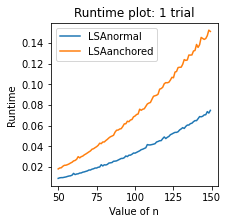

In [10]:
S1=randomString(1000)
S2=randomString(1000)

plotruntimes([lambda n:LSA(S1[:n],S2[:n],1 ,1),
              lambda n:LSA(S1[:n],S2[:n],1,1,11,50,)],
             ["LSAnormal","LSAanchored"],range(50,150))


As for the verbose function, there's a slight, flat complexity added(when = True) since it stores a couple more strings and takes time printing them. (sorry for the huge prints)

tatttcccgt
 atttcc gt
attgctgtta
attgctgt
tatttcccgta
 atttcc gta
attgctgttag
attgctgt a
tatttcccgtat
 atttcc gt t
attgctgttagg
attgctgtt
tatttcccgtatc
 atttcc gt t
attgctgttaggt
attgctgtt
tatttcccgtatct
 atttcc gt t
attgctgttaggtt
attgctgtt
tatttcccgtatctc
 atttcc gt t
attgctgttaggtta
attgctgtt
tatttcccgtatctcg
        gtat
attgctgttaggttat
           gt at
tatttcccgtatctcgc
        gtatc
attgctgttaggttatc
           gt atc
tatttcccgtatctcgcc
        gtatc c
attgctgttaggttatcc
           gt atcc
tatttcccgtatctcgccg
tatttccc
attgctgttaggttatccc
        ta  tt tccc
tatttcccgtatctcgccgc
tatttcccg
attgctgttaggttatcccg
        ta  tt tcccg
tatttcccgtatctcgccgct
        gt tctc ccgc
attgctgttaggttatcccgc
           gttatcccgc
tatttcccgtatctcgccgctg
        gtatctcgcc
attgctgttaggttatcccgcc
           gt atcccgcc
tatttcccgtatctcgccgctgt
        gtatctcgccg
attgctgttaggttatcccgccg
           gt atcccgccg
tatttcccgtatctcgccgctgtc
        gtatctcgccgc
attgctgttaggttatcccgccgc
           gt atcc

tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcat
        gtatctcgccgctgtcgcatctgt tg caagtacgg caacttgt a
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtgg
           gt atcccgccgcacactcaactattgcgact  accacaaa ttata
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcata
        gtatctcgccgctgtcgcatctgt tg caagtacgg caacttgt aacgaggt ggc
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggc
           gt atcccgccgcacactcaactattgcgact  accacaaa ttatag ctttgtggc
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataa
        gtatctcgccgctgtcgcatctgt tg caagtacgg caacttgt aacgaggt ggc t
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggct
           gt atcccgccgcacactcaactattgcgact  accacaaa ttatag ctttgtggct
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataac
        gtatctcgccgctgtcgcatctgt tg caagtacgg caacttgt aacgaggt ggc t
attgctgttaggttatcccgccgcacactcaac

tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtaga
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt ga
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccga
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g ggc g cgtga
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagac
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt ga
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccgag
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g ggc g cgtga
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagact
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt gact
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtg

tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagactcttatatttcttaccaaagg
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt gactc  atatttcttaccaa g
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccgagcaagcctcatggaagctaaca
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g ggc g cgtgaat   cacatt tccgagcaag
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagactcttatatttcttaccaaaggt
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt gactc  atatttcttaccaa g
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccgagcaagcctcatggaagctaacag
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g ggc g cgtgaat   cacatt tccgagcaag
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgc

tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagactcttatatttcttaccaaaggtcaattgggcatcagttc
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt gactc  atatttcttaccaa ggtca t gggcatcag
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccgagcaagcctcatggaagctaacagaatacacctggctgctg
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g ggc g cgtgaat   cacatt tccgagcaagc tcatgg  gc aacag
tatttcccgtatctcgccgctgtcgcatctgtgtgtcaagtacggtcaacttgtcaacgaggtcggcataacagcatataagctgggcgcgtagactcttatatttcttaccaaaggtcaattgggcatcagttcg
                          at tgtgt t aagtacgg caact   caacgagg cggcataacagcatataagctgggcgcgt gactc  atatttcttaccaa ggtca t gggcatcag
attgctgttaggttatcccgccgcacactcaactattgcgactttaccacaaaattataggctttgtggctgacgtgaatagacacattctccgagcaagcctcatggaagctaacagaatacacctggctgctgc
attg tgttaggt a c  g  gca actcaactat gcgactt a  acaaaat ataggct  g gg

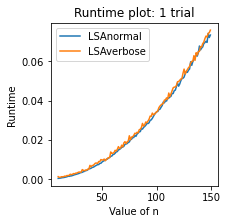

In [11]:
plotruntimes([lambda n:LSA(S1[:n],S2[:n],1 ,1),
              lambda n:LSA(S1[:n],S2[:n],1,1,verbose=True)],
             ["LSAnormal","LSAverbose"],range(10,150))

### Space

At its worst the function stores the entire edit graph/backtracking matrix so the main space use will be O(nm). Unfortunately, I could not implement the algorithm in Chapter 7.2 of the book on reducing the space usage to near O(n). As with my method of using an input to define a sink(anchors), there is no guarentee to find a mid point, as the longest path could be at and odd length.

At the start of the function, 2 empty numpy arrays are generated, I added an extra step to gradually set rows of the similarity graph to None, coupled with the fact that numpy arrays are very efficient(especially with empty arrays) this should not impact the overall space usage, outside the main takeup, the edit graph.

As for the anchors, when the function is ran with the anchors present, the space usage doubles to O(2nm), as 2 backtracking graphs are generated. This is very inefficient..

